Make sure to set the runtime to GPU: Runtime -> Change runtime type -> T4 GPU

You can upload your own images, then change the relevant code cells to load it and send it through the model.

In [2]:
# install the intrinsic decomposition repo from github and its dependencies
!pip install https://github.com/compphoto/Intrinsic/archive/main.zip
!pip install chrislib

     / 38.2 MB 28.0 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/MiDaS (to revision master) to /tmp/pip-install-ypevfzwr/altered-midas_1b61a35f43a94c63bf55a198e4ea58eb
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/MiDaS /tmp/pip-install-ypevfzwr/altered-midas_1b61a35f43a94c63bf55a198e4ea58eb
  Resolved https://github.com/CCareaga/MiDaS to commit fb51e3af860d9430e9aaeb1d30edd3b6e2ac0538
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/chrislib (to revision main) to /tmp/pip-install-ypevfzwr/chrislib_aeaeab97287140889fd52594481185b2
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/chrislib /tmp/pip-install-ypevfzwr/chrislib_aeaeab97287140889fd52594481185b2
  Resolved https://github.com/CCareaga/chrislib to commit 9a4c63f5fc5e7bbe62288f2777c527b706eb04d0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1

In [3]:
import torch
import numpy as np
from PIL import Image
import io
import skimage.transform

# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, invert
from chrislib.data_util import load_from_url

# import model loading and running the pipeline, and the underlying gray pipeline for more control
from intrinsic.pipeline import load_models, run_pipeline, run_gray_pipeline

In [4]:
# download the pretrained weights and return the model (may take a bit to download weights the first time)
intrinsic_model = load_models('v2')

loading v2 weights
Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_0.pt" to /root/.cache/torch/hub/checkpoints/stage_0.pt


100%|██████████| 403M/403M [00:10<00:00, 41.5MB/s]


Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_1.pt" to /root/.cache/torch/hub/checkpoints/stage_1.pt


100%|██████████| 81.8M/81.8M [00:01<00:00, 45.3MB/s]


Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_2.pt" to /root/.cache/torch/hub/checkpoints/stage_2.pt


100%|██████████| 403M/403M [00:10<00:00, 38.7MB/s]


Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_3.pt" to /root/.cache/torch/hub/checkpoints/stage_3.pt


100%|██████████| 403M/403M [00:10<00:00, 40.4MB/s]


Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v2.0/stage_4.pt" to /root/.cache/torch/hub/checkpoints/stage_4.pt


100%|██████████| 403M/403M [00:11<00:00, 37.3MB/s]


Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


100%|██████████| 340M/340M [00:01<00:00, 303MB/s]
/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


In [16]:
# load the image to run through the pipeline
# img = load_from_url('https://raw.githubusercontent.com/compphoto/Intrinsic/refs/heads/main/figures/canal.png')

from google.colab import files
import io
from PIL import Image
import torch
import numpy as np

print("Upload your image:")
uploaded = files.upload()

# Get the uploaded file content
# Assuming only one file is uploaded
for name, content in uploaded.items():
    uploaded_image_content = content
    print(f"Successfully uploaded file: {name}")
    break # We only expect one file

# Read the image using PIL and convert to PyTorch tensor
img_pil = Image.open(io.BytesIO(uploaded_image_content)).convert("RGB")

# Store original dimensions as global variables
global original_height, original_width
original_width, original_height = img_pil.size # PIL.Image.size is (width, height)

# Convert to PyTorch tensor without resizing here
img = torch.tensor(np.array(img_pil)).permute(2, 0, 1).float() / 255.0

print(f"Successfully loaded image of size: {img.shape} (Original: {original_width}x{original_height})")

Upload your image:


Saving view5.png to view5.png
Successfully uploaded file: view5.png
Successfully loaded image of size: torch.Size([3, 1110, 1330]) (Original: 1330x1110)


In [17]:
# run the image through the pipeline (runs all stages) using run_gray_pipeline for more control
result = run_gray_pipeline(
    intrinsic_model,
    img.permute(1, 2, 0).numpy(), # run_gray_pipeline expects HWC NumPy array
    maintain_size=True, # Set to True to bypass internal resizing and use the current image size
    device='cuda'
)

In [18]:
# The 'img' variable already holds your input image.
alb = view(result['gry_alb']) # gamma correct the estimated albedo
dif = 1 - invert(result['gry_shd']) # tonemap the diffuse shading
# 'residual' is not a direct output of run_gray_pipeline, so it's not included here.

DEBUG: img_np shape before ensure_consistent_size: (1110, 1330, 3)
DEBUG: alb shape before ensure_consistent_size: (1110, 1330, 3)
DEBUG: dif shape before ensure_consistent_size: (1110, 1330)
DEBUG: Entering ensure_consistent_size for img_np with shape: (1110, 1330, 3)
DEBUG: img_np already 1110x1330, no resize needed.
DEBUG: Entering ensure_consistent_size for alb with shape: (1110, 1330, 3)
DEBUG: alb already 1110x1330, no resize needed.
DEBUG: Entering ensure_consistent_size for dif with shape: (1110, 1330)
DEBUG: dif converted from 2D to 3D, new shape: (1110, 1330, 3)
DEBUG: dif already 1110x1330, no resize needed.
DEBUG: img_display shape: (1110, 1330, 3)
DEBUG: alb_display shape: (1110, 1330, 3)
DEBUG: dif_display shape: (1110, 1330, 3)


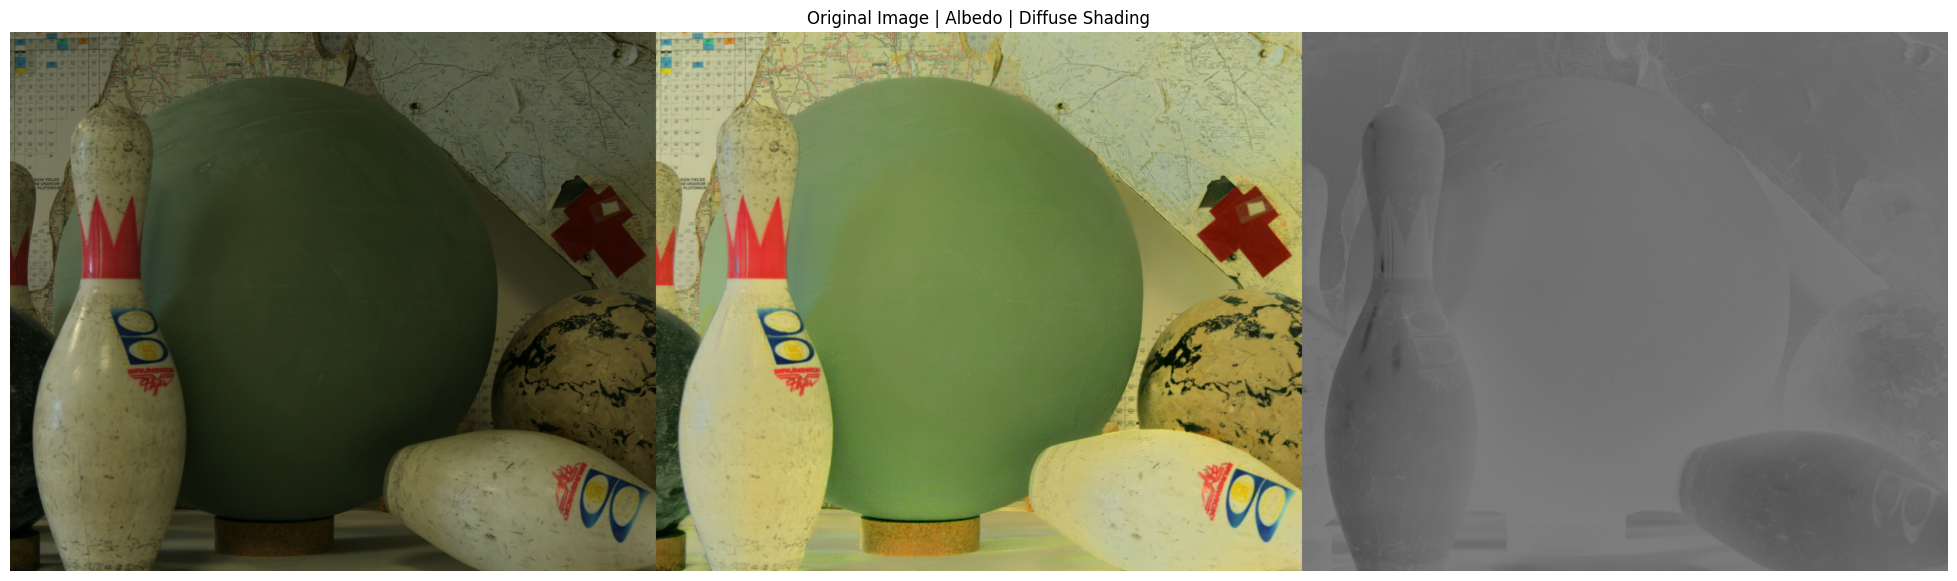

Albedo image saved as 'view5_A_d.png'
Diffuse shading image saved as 'view5_S_d.png'


In [19]:
import matplotlib.pyplot as plt
import skimage.transform
from PIL import Image # Import Pillow for saving images
import numpy as np # Ensure numpy is imported
import os # Import os module for path manipulation

# Prepare original image for display
# Check if img is a PyTorch tensor, and convert it to a NumPy array (H, W, C) if it is
if isinstance(img, torch.Tensor):
    img_np = img.permute(1, 2, 0).cpu().numpy()
else: # Assume it's already a NumPy array (H, W, C)
    img_np = img

print(f"DEBUG: img_np shape before ensure_consistent_size: {img_np.shape}")
print(f"DEBUG: alb shape before ensure_consistent_size: {alb.shape}")
print(f"DEBUG: dif shape before ensure_consistent_size: {dif.shape}")

# Explicitly resize all images to original uploaded size for consistent display if they are not already
def ensure_consistent_size(image_array, target_height, target_width, debug_name=""):
    print(f"DEBUG: Entering ensure_consistent_size for {debug_name} with shape: {image_array.shape}")
    # If the image is grayscale (2D), convert it to 3 channels by stacking
    if image_array.ndim == 2:
        image_array = np.stack([image_array, image_array, image_array], axis=-1)
        print(f"DEBUG: {debug_name} converted from 2D to 3D, new shape: {image_array.shape}")

    # Resize if dimensions are not the target_height x target_width
    if image_array.shape[0] != target_height or image_array.shape[1] != target_width:
        print(f"DEBUG: Resizing {debug_name} from {image_array.shape[:2]} to ({target_height}, {target_width})")
        resized_array = skimage.transform.resize(image_array, (target_height, target_width, 3), preserve_range=True, anti_aliasing=True)
        print(f"DEBUG: Resized {debug_name} shape: {resized_array.shape}")
        return resized_array
    print(f"DEBUG: {debug_name} already {target_height}x{target_width}, no resize needed.")
    return image_array

# Use the global original_height and original_width for target dimensions
img_display = (ensure_consistent_size(img_np, original_height, original_width, "img_np") * 255).astype(np.uint8)
alb_display = (ensure_consistent_size(alb, original_height, original_width, "alb") * 255).astype(np.uint8)
dif_display = (ensure_consistent_size(dif, original_height, original_width, "dif") * 255).astype(np.uint8)

print(f"DEBUG: img_display shape: {img_display.shape}")
print(f"DEBUG: alb_display shape: {alb_display.shape}")
print(f"DEBUG: dif_display shape: {dif_display.shape}")

# Manually concatenate the images horizontally
tiled_image = np.hstack([img_display, alb_display, dif_display])

# Display the tiled image using Matplotlib
plt.figure(figsize=(30, 7))
plt.imshow(tiled_image)
plt.axis('off')
plt.title('Original Image | Albedo | Diffuse Shading')
plt.show()

# Get the base name of the uploaded file
# 'name' variable holds the filename from the upload cell
base_filename, ext = os.path.splitext(name)

# Save albedo and diffuse shading images with modified names
albedo_filename = f"{base_filename}_A_d{ext}"
diffuse_shading_filename = f"{base_filename}_S_d{ext}"

Image.fromarray(alb_display).save(albedo_filename)
Image.fromarray(dif_display).save(diffuse_shading_filename)
print(f"Albedo image saved as '{albedo_filename}'")
print(f"Diffuse shading image saved as '{diffuse_shading_filename}'")

In [20]:
from google.colab import files

# Assuming 'albedo_filename' and 'diffuse_shading_filename' variables hold the paths
# from the previous saving step. If you ran that cell, these variables should be defined.

# Download the Albedo image
files.download(albedo_filename)

# Download the Diffuse Shading image
files.download(diffuse_shading_filename)

print(f"'{albedo_filename}' and '{diffuse_shading_filename}' have been downloaded to your local machine.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'view5_A_d.png' and 'view5_S_d.png' have been downloaded to your local machine.
